In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns


#import the test and train csv files
url_train = 'https://raw.githubusercontent.com/jiatianxie/MGMT6560_Project/master/train.csv'
url_test = 'https://raw.githubusercontent.com/jiatianxie/MGMT6560_Project/master/test.csv'

train = pd.read_csv(url_train)
test = pd.read_csv(url_test)

#drop unwanted categorical features

train = train.drop(['RescuerID','Description','PetID'], axis = 1)
test = test.drop(['RescuerID','Description','PetID'], axis = 1)

#add a column to create dummy feature for name. If a pet has name = 1, otherwise = 0.
train['With_Name'] = 0
test['With_Name'] = 0
train.loc[train['Name'] == 'No Name Yet', 'With_Name'] = 0
train.loc[train['Name'] != 'No Name Yet', 'With_Name'] = 1
test.loc[test['Name'] == 'No Name Yet', 'With_Name'] = 0
test.loc[test['Name'] != 'No Name Yet', 'With_Name'] = 1

#move the new colunm with_name to the front
cols_train = train.columns.tolist()
cols_train = cols_train[-1:] + cols_train[:-1]

cols_test = test.columns.tolist()
cols_test = cols_test[-1:] + cols_test[:-1]

train = train[cols_train]
test = test[cols_test]

#drop the name column, since it is categorical and it may not be very helpful
train = train.drop(['Name'], axis = 1)
test = test.drop(['Name'], axis = 1)

#insert a new column to specify data type
train.insert(20, 'dataset_type','train')
test.insert(20, 'dataset_type', 'test')

#Get a first look of the organized sets
test.head()

,With_Name,Type,Age,Breed1,Breed2,Gender,Color1,Color2,Color3,MaturitySize,FurLength,Vaccinated,Dewormed,Sterilized,Health,Quantity,Fee,State,VideoAmt,PhotoAmt,dataset_type
0,1,2,8,266,266,1,2,6,7,1,1,1,1,2,1,2,0,41326,0,2.0,test
1,1,2,36,285,264,2,1,4,7,2,3,1,1,1,2,1,0,41326,0,1.0,test
2,1,2,2,265,0,1,6,7,0,2,2,1,1,2,1,1,200,41326,0,4.0,test
3,1,1,12,307,0,2,2,5,0,2,2,1,1,1,1,2,0,41326,0,5.0,test
4,1,2,12,265,0,1,2,3,7,2,2,1,1,1,1,1,0,41326,0,5.0,test


Initial Processing

In [2]:
from scipy.stats import skew
from scipy.stats.stats import pearsonr

all_data = pd.concat((train.loc[:,'With_Name':'dataset_type'],
                      test.loc[:,'With_Name':'dataset_type']))


all_data.head()

,With_Name,Type,Age,Breed1,Breed2,Gender,Color1,Color2,Color3,MaturitySize,FurLength,Vaccinated,Dewormed,Sterilized,Health,Quantity,Fee,State,VideoAmt,PhotoAmt,dataset_type
0,1,2,3,299,0,1,1,7,0,1,1,2,2,2,1,1,100,41326,0,1.0,train
1,0,2,1,265,0,1,1,2,0,2,2,3,3,3,1,1,0,41401,0,2.0,train
2,1,1,1,307,0,1,2,7,0,2,2,1,1,2,1,1,0,41326,0,7.0,train
3,1,1,4,307,0,2,1,2,0,2,1,1,1,2,1,1,150,41401,0,8.0,train
4,1,1,1,307,0,1,1,0,0,2,1,2,2,2,1,1,0,41326,0,3.0,train


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: FutureWarning: `Series.plot()` should not be called with positional arguments, only keyword arguments. The order of positional arguments will change in the future. Use `Series.plot(kind='barh')` instead of `Series.plot('barh',)`.
  """Entry point for launching an IPython kernel.


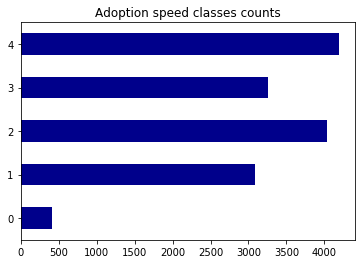

In [3]:
#adoption speed count
train['AdoptionSpeed'].value_counts().sort_index().plot('barh', color='darkblue');
plt.title('Adoption speed classes counts');

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f24fe0e4ba8>,
      dtype=object)

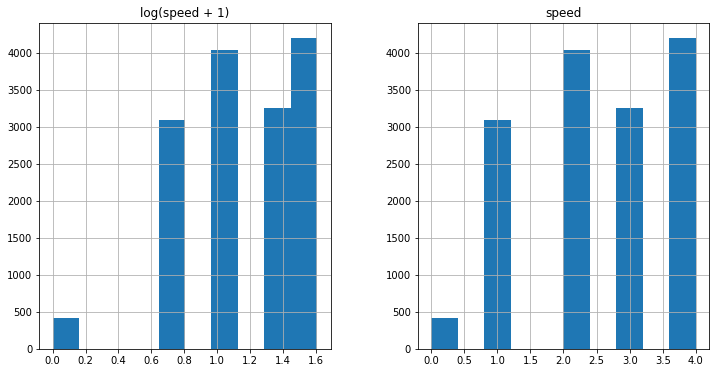

In [4]:
#transform the skewed numeric features by taking log(feature + 1) so that the features are more normal
matplotlib.rcParams['figure.figsize'] = (12.0, 6.0)
speed = pd.DataFrame({"speed":train["AdoptionSpeed"], "log(speed + 1)":np.log1p(train["AdoptionSpeed"])})
speed.hist()

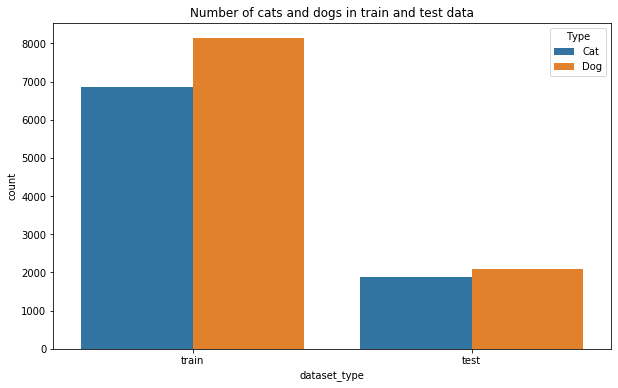

In [5]:
#number of dogs and cats in each dataset
all_data['Type'] = all_data['Type'].apply(lambda x: 'Dog' if x == 1 else 'Cat')
plt.figure(figsize=(10, 6));
sns.countplot(x='dataset_type', data=all_data, hue='Type');
plt.title('Number of cats and dogs in train and test data');

The Ridge Regression and Lasso Model

In [0]:
all_data = pd.concat((train.loc[:,'With_Name':'PhotoAmt'],
                      test.loc[:,'With_Name':'PhotoAmt']))

#log transform the target:
train["AdoptionSpeed"] = np.log1p(train["AdoptionSpeed"])

#log transform skewed numeric features:
numeric_feats = all_data.dtypes[all_data.dtypes != "object"].index

skewed_feats = train[numeric_feats].apply(lambda x: skew(x.dropna())) #compute skewness
skewed_feats = skewed_feats[skewed_feats > 0.75]
skewed_feats = skewed_feats.index

all_data[skewed_feats] = np.log1p(all_data[skewed_feats])

In [0]:
#create matrices for sklearn
X_train = all_data[:train.shape[0]]
X_test = all_data[train.shape[0]:]
y = train.AdoptionSpeed

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
/usr

Text(0, 0.5, 'rmse')

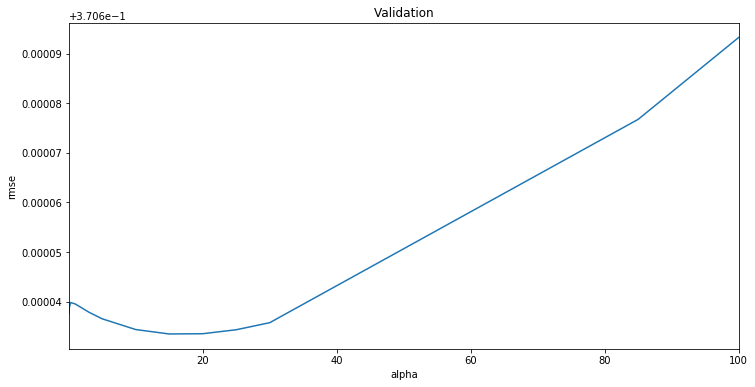

In [8]:
from sklearn.linear_model import Ridge, RidgeCV, ElasticNet, LassoCV, LassoLarsCV
from sklearn.model_selection import cross_val_score

def rmse_cv(model):
    rmse= np.sqrt(-cross_val_score(model, X_train, y, scoring="neg_mean_squared_error"))
    return(rmse)

model_ridge = Ridge()

alphas = [0.05, 0.1, 0.3, 1, 3, 5, 10, 15, 20, 25, 30,85,100]
cv_ridge = [rmse_cv(Ridge(alpha = alpha)).mean()
            for alpha in alphas]

cv_ridge = pd.Series(cv_ridge, index = alphas)
cv_ridge.plot(title = "Validation")
plt.xlabel("alpha")
plt.ylabel("rmse")

In [9]:
#The plot shows that an alpha of 20 the best fit for ridge regression
#the rmse for ridge regression

model_ridge.fit(X_train, y)
ridge_preds = np.expm1(model_ridge.predict(X_test))

print('The rmse for ridge regression:', cv_ridge.min())

The rmse for ridge regression: 0.37063348307639127


In [10]:
#The plot shows that an alpha of 30 is the best fit for ridge regression

model_lasso = LassoCV(alphas = [1, 0.6, 0.02, 0.05, 0.005 ,0.001 ,0.0005]).fit(X_train, y)
lasso_preds = np.expm1(model_lasso.predict(X_test))

print('The rmse for Lasso:', rmse_cv(model_lasso).mean())

The rmse for Lasso: 0.37068492618484356


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
/usr

In [11]:
coef = pd.Series(model_lasso.coef_, index = X_train.columns)
print("Ridge picked " + str(sum(coef != 0)) + " variables and eliminated the other " +  str(sum(coef == 0)) + " variables")

Ridge picked 16 variables and eliminated the other 4 variables


Text(0.5, 1.0, 'Coefficients in the Lasso Model')

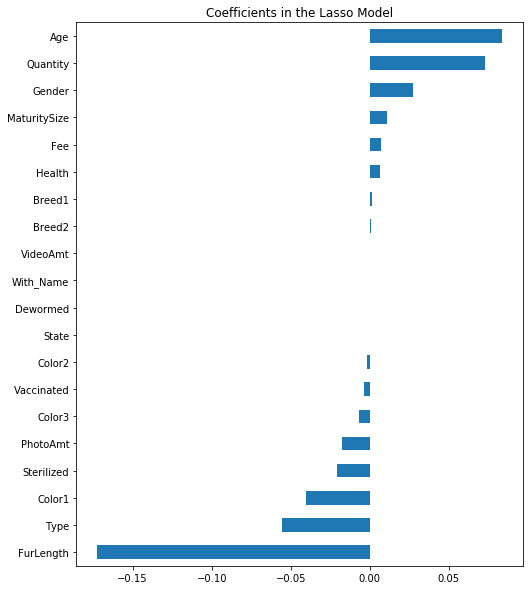

In [12]:
#plot the coefficients in the Lasso Model for different variables

coef = pd.Series(model_lasso.coef_, index = X_train.columns)
imp_coef = pd.concat([coef.sort_values().head(10),
                     coef.sort_values().tail(10)])

matplotlib.rcParams['figure.figsize'] = (8.0, 10.0)
imp_coef.plot(kind = "barh")
plt.title("Coefficients in the Lasso Model")

XGBoost Model

In [13]:
!conda install -c conda-forge -y xgboost #run this if not running on colab

/bin/bash: conda: command not found


In [14]:
import xgboost as xgb

#reassign train and test set
X_train = train.loc[:,'With_Name':'PhotoAmt']
X_test = test.loc[:,'With_Name':'PhotoAmt']
y = train['AdoptionSpeed']

dtrain = xgb.DMatrix(X_train, label = y)
dtest = xgb.DMatrix(X_test)

params = {"max_depth":5, "eta":0.05}

model = xgb.cv(params, dtrain,  num_boost_round=500, early_stopping_rounds=100)

/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


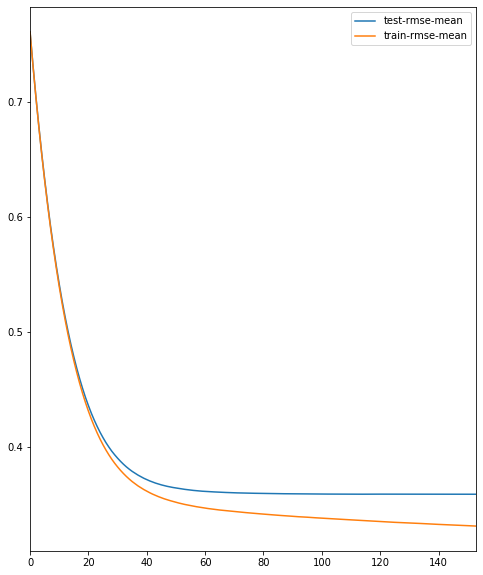

In [15]:
model.loc[:,["test-rmse-mean", "train-rmse-mean"]].plot()

In [16]:
model_xgb = xgb.XGBRegressor(n_estimators=1000, max_depth=5, learning_rate=0.05) #the params were tuned using xgb.cv
model_xgb.fit(X_train, y)

/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[06:12:24] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.05, max_delta_step=0,
             max_depth=5, min_child_weight=1, missing=None, n_estimators=1000,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)

In [17]:
#XGbooster prediction
xgb_preds = np.expm1(model_xgb.predict(X_test))
xgb_preds

array([2.9118927, 1.7933164, 1.677594 , ..., 3.0654798, 3.0273702,
       2.2823482], dtype=float32)

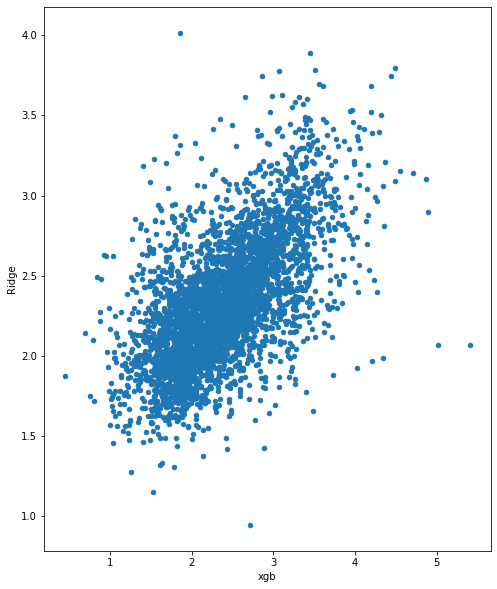

In [18]:
#compare lasso and xgb results

predictions = pd.DataFrame({"xgb":xgb_preds, "Ridge":ridge_preds})
predictions.plot(x = "xgb", y = "Ridge", kind = "scatter")

In [19]:
#make an ensamble model to combine the ridge and xgb prediction.
preds = 0.5*lasso_preds + 0.5*xgb_preds

#top 100 adoption speed prediction for pets in the test dataset
print(preds[0:99])

[2.61799034 2.19537834 1.72726437 2.95659809 2.28428322 1.91465651
 2.39530832 1.86769228 2.18118658 2.14073477 2.68655955 3.0080205
 2.05737443 2.03237988 2.14285617 2.06867267 1.96965822 2.53030301
 2.23385145 1.94695007 2.54844933 3.59594054 2.2424774  3.2651925
 2.23385145 2.13845732 2.41666169 3.48007871 2.34197317 2.48829951
 2.04911141 1.97269066 2.63074626 2.30378237 3.22898518 3.37592008
 2.89959821 2.70794583 2.92875678 1.60604537 3.23106065 2.59805282
 3.03834688 2.16594326 2.09120475 2.63928336 2.89511354 2.93384961
 2.76305794 2.46488058 3.2045077  2.55997926 2.58523822 2.7155664
 2.54487677 2.19493698 3.20473868 2.91276516 2.53450803 2.74413319
 2.35297604 2.72032794 2.12672119 3.15307697 2.95435999 2.53878803
 2.68238101 3.4385781  2.15670486 2.85651015 2.74004321 2.66572577
 3.59306395 2.87030276 2.55942715 2.17450066 2.37929823 2.65031418
 2.61628544 2.95146803 2.06657084 2.30037353 3.06662059 2.61031037
 3.1853353  2.74612071 3.43697315 2.38353071 3.45299993 3.1574676